# RNNによる文章生成

---

#### 前準備

- 今回は前章で作成したRnnlm, BetterRnnlmも使用するためこちらに事前に記載しておく

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from common.base_model import BaseModel
from common.functions import softmax, sigmoid
from common.optimizer import Adam
from common.trainer import Trainer
from common.time_layers import *
from common.util import eval_seq2seq
from dataset import ptb, sequence

In [48]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f) 

In [49]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 改善
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),  # Dropout層の追加
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),  # LSTMレイヤの追加
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 重み共有
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs, train_fig=False):
        for layer in self.drop_layers:
            layer.train_fig = train_fig
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

---

## 言語モデルを使った文章生成

- 言語モデルに単語を与えた際, その次の単語を新たに生成する方法は2つ
  - 決定的方法: 次に来る確率が最も高い単語を選ぶ → 結果が一意に定まる
  - 確率的方法: 確率分布に従い選ぶことで, 高確率の単語ほど選ばれやすくなる → 結果は毎回異なる
  
※前章のモデル生成が追いついていないので本家リポジトリ等から重みは拝借

In [50]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

In [51]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params("./Original_Rnnlm.pkl")

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', "$"]
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
words_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in words_ids])
txt = txt.replace('<eos>', '\n')
print(txt)

you mcnamee ultimately till asian inning been accustomed establishment vincent attract issuers seal floors stoll we dismal selling femina tissue leaders recognize manufactures revolution n.v. staffers summoned telling pons edged noise dubbed creatures styles claims pot meet was pot extra requiring individual indonesia factors benchmark appealed jobless policy respond airing climb chivas face-to-face cafeteria averaging roy hdtv granted war rebel madison examiner hard-line ed lipton longer germans gum cost-of-living norwegian buildup photograph saving chairman flow delaying sight creditors cadillac diamonds foreign-exchange departures businessmen dealerships lost direction disposal unpaid optimistic plead staffs quarter alabama stations budget encouraged ark mortgage-backed optimism advises


- 上の例だと部分部分では意味が通じている箇所はあるもののまだ不自然な部分が多い
  - 上記のモデルはパープレキシティがおよそ136程度のため
  - パープレキシティを75まで改良した方の重みを用いてみる

In [52]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [53]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('./Original_BetterRnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you can secure the company 's marketing business.
 so many of mr. recognizes clearly flying clients who accounted for almost half phone and engaged in detroit.
 but mr. straszheim also felt he.
 he added more.
 saturday frequently privilege as directors has been quoted for months with the high warranty because all mrs. pages may be reached michael report.
 it could be earlier in the quarter and there might lead to family as well.
 because this investment is traditionally revised by the financial markets says mr. butler the responsibility of soviet banking and late chairman
--------------------------------------------------
the meaning of life is contemplated by telesis 's profit to reduce its operations in waterworks next year.
 mr. also noted that and statistics now account for much of the paper continental advertising silver flow likely of a assets of a company 's medical.
 in light trips in a state holding company business executives and british savings & loan chemical holding s.a. 

- 当初のと比べ更に文章は自然的なものになったように思われる

---

## seq2seq

- 時系列データを別の時系列データに変換する手法
  - 2つのRNNを利用する
  - 別名Encoder-Decoderモデルとも呼ばれる
  
- 入力された文章をEncoderによって符号化し, その符号化情報をDecorderに渡しデコードすることで目的とする文章を生成する
  - 機械翻訳などをイメージするとわかりやすいかも
  
- Encoderで行っていること: 文章を固定長のベクトル$h$に変換する
  - この$h$はRNN(LSTMやGRUでも良い)レイヤの最後の隠れ状態

- Decoderは$h$を入力とし, 上記で試したような文章生成を行うモデルを利用することで生成が可能となる
  - 実際には上記のモデルは入力$h$を受け取っていないため, その部分を変える必要がある
  
---

### 時系列データ変換用のトイ・プロブレム

- トイ・プロブレム: 機械学習を評価する際に作られた簡単な問題
- ここでは足し算問題を扱う
  - 上記は"you"などの単語単位だったが, ここでは文字単位で行う

- 足し算の問題文("10+3", "214+57" など)によって文字数が異なる(i.e. 可変長の時系列データである)
  - 可変長の時系列データのシンプルな対策としてパディングによる入力データの長さ統一が挙げられる

In [54]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]])) # _はパディングの為の空白文字部分

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


---

## seq2seqの実装

### Encoderクラス

- Embeddingレイヤ, LSTMレイヤによって構成される
- Affineレイヤ以降が無く, 時系列方向にのみ出力ができれば良いので次レイヤ方面への出力は破棄する

In [73]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

---

### Decoderクラス

- 先の文章生成と異なり今回は確率的な揺れを排除するため決定的な選択手法を取る
- DecoderはRNNで実現可能(ただし学習時と生成時でSoftmax with Lossレイヤの扱いが異なる)
  - 学習時の流れ: Embedding → LSTM → Affine → Softmax with Loss → Loss
  - 生成時の流れ: Embedding → LSTM → Affine → argmax →Softmax with Loss → Loss

In [74]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        self.params, self.grads = [], []
        
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

---

### seq2seqクラス

- Encoderクラス, Decoderクラスをつなぎ合わせTime Softmax with Lossレイヤによる損失計算を行う
  - 学習と文章生成とでDecoderのSoftmax with Lossの挙動が異なる為, こちらのクラスで定義

In [75]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

---

### seq2seqの評価

- seq2seqの学習手順も基本的なNNの学習と同じ流れで行う

In [76]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3lf%%' % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 4[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 5[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 6[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 7[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 8[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 9[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 10[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 11[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 12[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 13[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 14[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 15[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 16[s] | loss 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+8

| epoch 7 |  iter 321 / 351 | time 16[s] | loss 1.06
| epoch 7 |  iter 341 / 351 | time 17[s] | loss 1.04
Q 77+85  
T 162 
X 156 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 656 
---
Q 8+155  
T 163 
X 141 
---
Q 367+55 
T 422 
X 402 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1031
---
Q 830+597
T 1427
X 1374
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 217 
---
val acc 3.180%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 1.06
| epoch 8 |  iter 21 / 351 | time 1[s] | loss 1.06
| epoch 8 |  iter 41 / 351 | time 2[s] | loss 1.08
| epoch 8 |  iter 61 / 351 | time 3[s] | loss 1.04
| epoch 8 |  iter 81 / 351 | time 4[s] | loss 1.08
| epoch 8 |  iter 101 / 351 | time 5[s] | loss 1.06
| epoch 8 |  iter 121 / 351 | time 6[s] | loss 1.04
| epoch 8 |  iter 141 / 351 | time 8[s] | loss 1.04
| epoch 8 |  iter 161 / 351 | time 9[s] | loss 1.04
| epoch 8 |  iter 181 / 351 | time 10[s] | loss 1.03
| epoch 8 |  iter 201 / 351 | time 11[s] | loss 1.03
| epoch 8 |  iter 221 / 351 | t

| epoch 14 |  iter 141 / 351 | time 7[s] | loss 0.91
| epoch 14 |  iter 161 / 351 | time 8[s] | loss 0.91
| epoch 14 |  iter 181 / 351 | time 9[s] | loss 0.90
| epoch 14 |  iter 201 / 351 | time 10[s] | loss 0.87
| epoch 14 |  iter 221 / 351 | time 11[s] | loss 0.90
| epoch 14 |  iter 241 / 351 | time 12[s] | loss 0.92
| epoch 14 |  iter 261 / 351 | time 13[s] | loss 0.92
| epoch 14 |  iter 281 / 351 | time 14[s] | loss 0.90
| epoch 14 |  iter 301 / 351 | time 15[s] | loss 0.89
| epoch 14 |  iter 321 / 351 | time 16[s] | loss 0.89
| epoch 14 |  iter 341 / 351 | time 17[s] | loss 0.90
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1121
---
Q 582+84 
T 666 
X 658 
---
Q 8+155  
T 163 
X 171 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 859 
---
Q 761+292
T 1053
X 1070
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 859 
---
Q 143+93 
T 236 
X 238 
---
val acc 7.640%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.86
| epoch 15 |  iter 21 / 351 | time 1[s] | loss 0.92
| epoch 15 

val acc 4.800%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.88
| epoch 21 |  iter 21 / 351 | time 1[s] | loss 0.83
| epoch 21 |  iter 41 / 351 | time 2[s] | loss 0.83
| epoch 21 |  iter 61 / 351 | time 3[s] | loss 0.81
| epoch 21 |  iter 81 / 351 | time 4[s] | loss 0.84
| epoch 21 |  iter 101 / 351 | time 5[s] | loss 0.81
| epoch 21 |  iter 121 / 351 | time 6[s] | loss 0.82
| epoch 21 |  iter 141 / 351 | time 7[s] | loss 0.88
| epoch 21 |  iter 161 / 351 | time 8[s] | loss 0.81
| epoch 21 |  iter 181 / 351 | time 9[s] | loss 0.80
| epoch 21 |  iter 201 / 351 | time 10[s] | loss 0.79
| epoch 21 |  iter 221 / 351 | time 11[s] | loss 0.80
| epoch 21 |  iter 241 / 351 | time 12[s] | loss 0.80
| epoch 21 |  iter 261 / 351 | time 13[s] | loss 0.80
| epoch 21 |  iter 281 / 351 | time 14[s] | loss 0.84
| epoch 21 |  iter 301 / 351 | time 15[s] | loss 0.82
| epoch 21 |  iter 321 / 351 | time 16[s] | loss 0.83
| epoch 21 |  iter 341 / 351 | time 17[s] | loss 0.82
Q 77+85  
T 162 
O 162 
---
Q

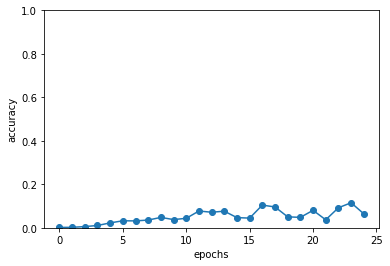

In [77]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

---

### seq2seqの改良

1. 入力データの反転(Reverse)
  - 理論的な事は不明だが 直感的には勾配の伝播がスムーズになるからだと考えられる
  - 以下のようにすればいいだけなのでシンプル
  ```py
  x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
  ```
  
2. 覗き見(Peeky)
  - 従来最初の時刻のLSTMのみが利用していたEncoderの出力hを, 全ての時刻のDecoderのAffine, LSTMに与える
  

In [82]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [79]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [81]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0
is_reverse = True

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 4[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 5[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 6[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 7[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 8[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 9[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 10[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 11[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 12[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 13[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 14[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 15[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 16[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 17[s] | loss 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+

| epoch 7 |  iter 321 / 351 | time 17[s] | loss 0.54
| epoch 7 |  iter 341 / 351 | time 18[s] | loss 0.53
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 156 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1052
---
Q 830+597
T 1427
X 1428
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 235 
---
val acc 39.100%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.51
| epoch 8 |  iter 21 / 351 | time 1[s] | loss 0.50
| epoch 8 |  iter 41 / 351 | time 2[s] | loss 0.49
| epoch 8 |  iter 61 / 351 | time 3[s] | loss 0.48
| epoch 8 |  iter 81 / 351 | time 4[s] | loss 0.47
| epoch 8 |  iter 101 / 351 | time 5[s] | loss 0.46
| epoch 8 |  iter 121 / 351 | time 6[s] | loss 0.46
| epoch 8 |  iter 141 / 351 | time 7[s] | loss 0.44
| epoch 8 |  iter 161 / 351 | time 8[s] | loss 0.41
| epoch 8 |  iter 181 / 351 | time 9[s] | loss 0.42
| epoch 8 |  iter 201 / 351 | time 11[s] | loss 0.41
| epoch 8 |  iter 221 / 351 | t

| epoch 14 |  iter 121 / 351 | time 6[s] | loss 0.05
| epoch 14 |  iter 141 / 351 | time 7[s] | loss 0.05
| epoch 14 |  iter 161 / 351 | time 9[s] | loss 0.05
| epoch 14 |  iter 181 / 351 | time 10[s] | loss 0.05
| epoch 14 |  iter 201 / 351 | time 11[s] | loss 0.05
| epoch 14 |  iter 221 / 351 | time 12[s] | loss 0.06
| epoch 14 |  iter 241 / 351 | time 13[s] | loss 0.06
| epoch 14 |  iter 261 / 351 | time 14[s] | loss 0.07
| epoch 14 |  iter 281 / 351 | time 16[s] | loss 0.06
| epoch 14 |  iter 301 / 351 | time 17[s] | loss 0.06
| epoch 14 |  iter 321 / 351 | time 18[s] | loss 0.05
| epoch 14 |  iter 341 / 351 | time 19[s] | loss 0.05
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
val acc 94.660%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.05
| epoch 

val acc 95.120%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.03
| epoch 21 |  iter 21 / 351 | time 1[s] | loss 0.02
| epoch 21 |  iter 41 / 351 | time 2[s] | loss 0.02
| epoch 21 |  iter 61 / 351 | time 3[s] | loss 0.02
| epoch 21 |  iter 81 / 351 | time 4[s] | loss 0.02
| epoch 21 |  iter 101 / 351 | time 5[s] | loss 0.02
| epoch 21 |  iter 121 / 351 | time 6[s] | loss 0.02
| epoch 21 |  iter 141 / 351 | time 7[s] | loss 0.02
| epoch 21 |  iter 161 / 351 | time 8[s] | loss 0.02
| epoch 21 |  iter 181 / 351 | time 10[s] | loss 0.01
| epoch 21 |  iter 201 / 351 | time 11[s] | loss 0.02
| epoch 21 |  iter 221 / 351 | time 12[s] | loss 0.01
| epoch 21 |  iter 241 / 351 | time 13[s] | loss 0.01
| epoch 21 |  iter 261 / 351 | time 14[s] | loss 0.01
| epoch 21 |  iter 281 / 351 | time 16[s] | loss 0.01
| epoch 21 |  iter 301 / 351 | time 17[s] | loss 0.01
| epoch 21 |  iter 321 / 351 | time 18[s] | loss 0.01
| epoch 21 |  iter 341 / 351 | time 19[s] | loss 0.01
Q 77+85  
T 162 
O 162 
---

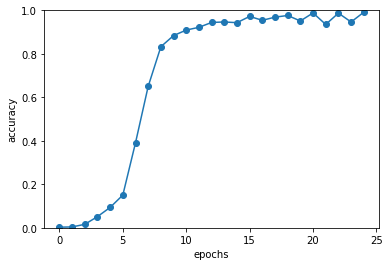

In [83]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()